<a href="https://colab.research.google.com/github/albertofernandezvillan/computer-vision-and-deep-learning-course/blob/main/keras_applications_feature_extraction_for_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" style="padding-right:10px;" src ="https://raw.githubusercontent.com/albertofernandezvillan/computer-vision-and-deep-learning-course/main/assets/university_oviedo_logo.png" width=300 px>

This notebook is from the Course "***Computer vision in the new era of Artificial Intelligence and Deep Learning***", or "*Visión por computador en la nueva era de la Inteligencia Artificial y el Deep Learning*" (ES) from the "Second quarter university extension courses" that the University of Oviedo is offering (05/04/2021 - 16/04/2021)

<[Github Repository](https://github.com/albertofernandezvillan/computer-vision-and-deep-learning-course) | [Course Web Page Information](https://www.uniovi.es/estudios/extension/cursos2c/-/asset_publisher/SEp0PJi4ISGo/content/vision-por-computador-en-la-nueva-era-de-la-inteligencia-artificial-y-el-deep-learning?redirect=%2Festudios%2Fextension%2Fcursos2c)>

# Summary
Keras Applications are deep learning models that are made available alongside pre-trained weights. These models can be used for prediction, feature extraction, and fine-tuning.

In this example, we are going to see how to use them for feature extraction. These features will be used as input for a clustering task. For more information about Keras Applications, see https://keras.io/api/applications/

At the end of this notebook, you will be creating a binary classifier to classify dog vs cat images using a [KMeans clustering algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). The features used as input to this classifier are going to be generated using a pre-trained [VGG16 model](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16).  

For futher information, you can check other related online resources:

*   [Using Keras’ Pre-trained Models for Feature Extraction in Image Clustering](https://franky07724-57962.medium.com/using-keras-pre-trained-models-for-feature-extraction-in-image-clustering-a142c6cdf5b1)

*   [Transfer Learning with Keras and Deep Learning](https://www.pyimagesearch.com/2019/05/20/transfer-learning-with-keras-and-deep-learning/)

*   [Transfer Learning in Keras with Computer Vision Models](https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/)

*   [A Detailed Introduction to K-means Clustering in Python](https://www.analyticsvidhya.com/blog/2020/12/a-detailed-introduction-to-k-means-clustering-in-python/)

*   [(ES) K-Means en Python paso a paso](https://www.aprendemachinelearning.com/k-means-en-python-paso-a-paso/)

*   [K-Means Clustering in Python: A Practical Guide](https://realpython.com/k-means-clustering-python/)

Finally, it is also recommended to check first this notebook "[keras_applications_feature_extraction_for_classification.ipynb](https://github.com/albertofernandezvillan/computer-vision-and-deep-learning-course/blob/main/keras_applications_feature_extraction_for_classification.ipynb)", which introduces with a more detail `keras.applications` for feature extraction purposes. 

# Download the dataset from Kaggle
We will download a dataset from Kaggle.
A detail information about how to install kaggle API, configure it and check that it works can be seen in the notebook "[set_up_kaggle_api_in_colab.ipynb](https://github.com/albertofernandezvillan/computer-vision-and-deep-learning-course/blob/main/set_up_kaggle_api_in_colab.ipynb)" in this [course repository](https://github.com/albertofernandezvillan/computer-vision-and-deep-learning-course)

In [1]:
# Install kaggle API
! pip install kaggle
# Force install the latest version
! pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 4.8MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=c11dda7dbdeda5745297c7757a22824712f1220bcebdaed3accb6fc39588be69
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [2]:
# Upload 'kaggle.json' file to Colab
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
# Move the uploaded file to a location ~/.kaggle/kaggle.json. 
# Additionally, you need to give proper permissions to the file (since this is a hidden folder). 
# Finally delete the kaggle.json file from the initial location
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! rm kaggle.json

In [4]:
# Checking that it works (optional). For example, run the following command:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes        107           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        212           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        571           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       3506           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      28363            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       7262           False  
connectx

Download the cats-dogs dataset from Kaggle and unzip it.

In [5]:
# Download cats-dogs dataset and unzip it:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition
!unzip dogs-vs-cats-redux-kernels-edition

 97% 793M/814M [00:03<00:00, 287MB/s]
100% 814M/814M [00:03<00:00, 274MB/s]
Archive:  dogs-vs-cats-redux-kernels-edition.zip
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.zip               


We can include `%%capture` magic command to suppress the output.

In [7]:
%%capture
!unzip train.zip -d train
!unzip test.zip -d test

In [6]:
train_dir = '/content/train/train'
test_dir = '/content/test/test'

# Introducing `keras.applications` for feature extraction
We are going to see how to perform feature extraction using [VGG16 model](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16). These features are extracted from a test image included in the repository. The first step is to import the required packages.

it is recommended to check first this notebook "[keras_applications_feature_extraction_for_classification.ipynb](https://github.com/albertofernandezvillan/computer-vision-and-deep-learning-course/blob/main/keras_applications_feature_extraction_for_classification.ipynb)", which introduces with a more detail `keras.applications` for feature extraction purposes. 

In [8]:
# Import required packages
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

We load the weights from 'imagenet' (pre-trained on ImageNet). Note also `include_top` parameter: whether to include the 3 fully-connected layers at the top of the network. In this case, these layers are not included.

In [9]:
# Load the model 
model = VGG16(weights="imagenet", include_top=False)

58892288/58889256 [==============================] - 0s 0us/step


You can explore the loaded model using both `model.summary` and `plot_model` to understand what have been created and loaded.

In [10]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

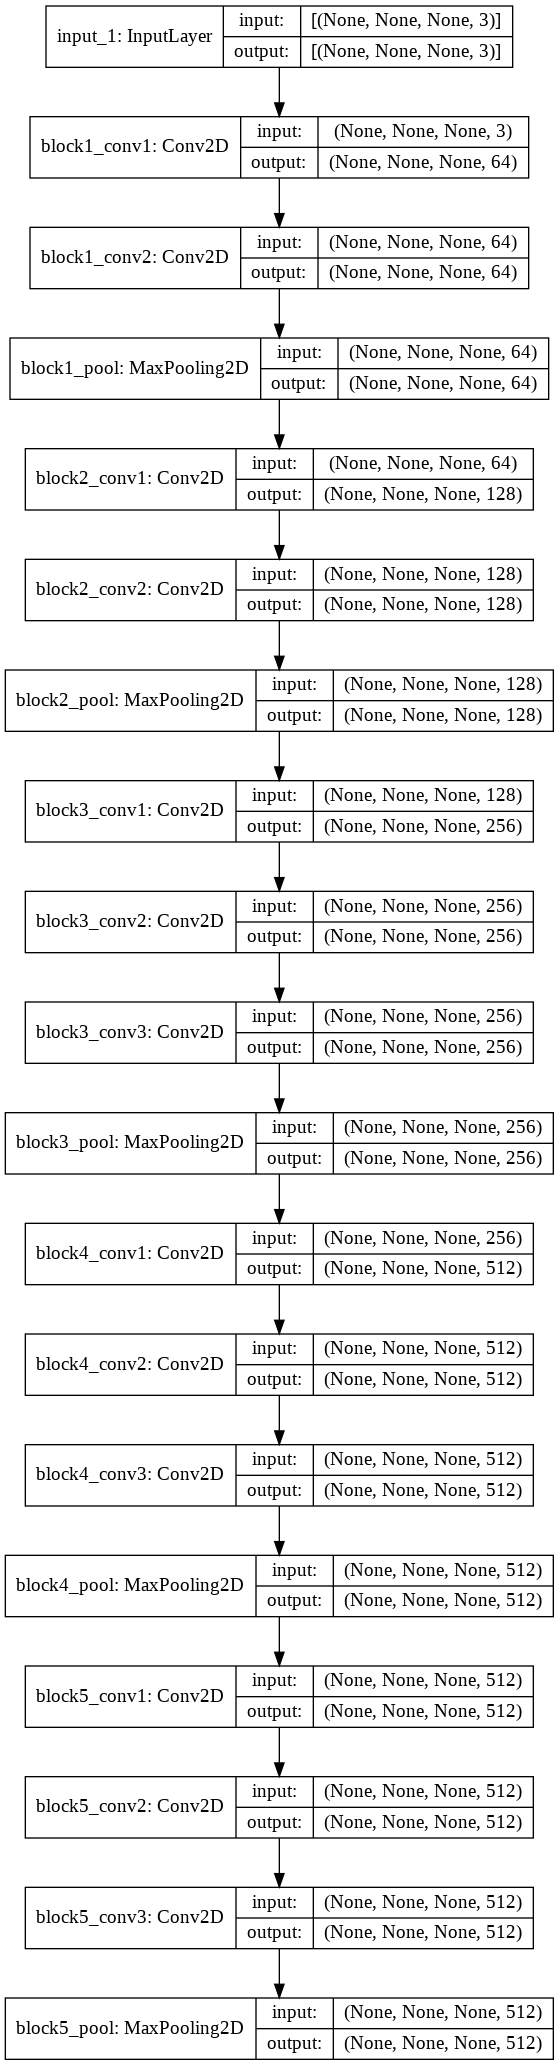

In [11]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='VGG16_without_fc_layers.png', show_shapes=True, show_layer_names=True)

We download a test image from the repository. This image will be used later (as an example) to extract the features from it using our feature extractor model.

In [12]:
# Download the image from the repository and rename it to 'sample.png':
!wget https://raw.githubusercontent.com/albertofernandezvillan/computer-vision-and-deep-learning-course/main/assets/lenna.png -O sample.png

--2021-04-03 16:27:54--  https://raw.githubusercontent.com/albertofernandezvillan/computer-vision-and-deep-learning-course/main/assets/lenna.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88235 (86K) [image/png]
Saving to: ‘sample.png’

sample.png          100%[===================>]  86.17K  --.-KB/s    in 0.009s  

2021-04-03 16:27:54 (8.87 MB/s) - ‘sample.png’ saved [88235/88235]



At this point, we can extract the features from the image. We also show the shape of the extracted features:

In [13]:
import numpy as np

image = load_img('/content/sample.png', target_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = preprocess_input(image)

vgg16_feature = model.predict(image)
# The output dimension of the max-pooling layer is (batch_size, 7, 7, 512)
# In this case, as we are only predicting one image will be (1, 7, 7, 512)
print("Shape of the features: '{}'".format(vgg16_feature.shape))

vgg16_feature_flatten = vgg16_feature.flatten()
print("Shape of the (flatten) features: '{}'".format(vgg16_feature_flatten.shape))

Shape of the features: '(1, 7, 7, 512)'
Shape of the (flatten) features: '(25088,)'


At this point, we can create the function `get_features()`, which receives the path of the image and returns the features in the form of a flatten array. See also the included example in order to see how this function works.

In [14]:
# Based on previous inspection, we create a function that receives the path
# of the image and returns the features in the form of a flatten array

import numpy as np

def get_features(path_image):
  img = load_img(path_image, target_size=(224, 224))
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = preprocess_input(img)

  vgg16_feats= model.predict(img)
  vgg16_feats_flat = vgg16_feats.flatten()

  return vgg16_feats_flat

# Test this function:
print("Shape of the features: '{}'".format(get_features('/content/sample.png').shape))

Shape of the features: '(25088,)'


# Train the classifier to distinguish between cat and dogs

We are going to train a classifier to distinguish between images containing cats and images containing dogs. To do it, we are going to train a [KMeans clustering algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). Note that we are going to use `N_CATS` and `N_DOGS` images to train this classifier. Further experiments can be added to see the minimum (or the optimal) number of images needed to train this classifier.


What we are going to do next is to extract the features from the first `N_CATS` and `N_DOGS` images included in the `train_dir` directory. All the extracted features are appended to `vgg16_feature_list` structure.

In [15]:
import os

N_CATS = 100
N_DOGS = 100

curr_dogs = 0
curr_cats = 0

vgg16_feature_list = []

for filename in os.listdir(train_dir):
  path_image = os.path.join(train_dir, filename)

  # check if we have finished extracting features:
  if curr_cats > N_CATS and curr_dogs > N_DOGS:
    print("we are done")
    break

  if "cat" in filename:
    curr_cats += 1
  
  if "dog" in filename:
    curr_dogs += 1
  
  if "cat" in filename and curr_cats > N_CATS:
    continue

  if "dog" in filename and curr_dogs > N_DOGS:
    continue

  print("image {}, curr cats: {}, curr dogs: {}".format(filename, curr_cats, curr_dogs))

  features = get_features(path_image)
  vgg16_feature_list.append(features)

image cat.2826.jpg, curr cats: 1, curr dogs: 0
image cat.6900.jpg, curr cats: 2, curr dogs: 0
image cat.9517.jpg, curr cats: 3, curr dogs: 0
image dog.9156.jpg, curr cats: 3, curr dogs: 1
image dog.9681.jpg, curr cats: 3, curr dogs: 2
image dog.7388.jpg, curr cats: 3, curr dogs: 3
image dog.1554.jpg, curr cats: 3, curr dogs: 4
image cat.391.jpg, curr cats: 4, curr dogs: 4
image dog.12247.jpg, curr cats: 4, curr dogs: 5
image dog.2895.jpg, curr cats: 4, curr dogs: 6
image dog.11794.jpg, curr cats: 4, curr dogs: 7
image dog.9169.jpg, curr cats: 4, curr dogs: 8
image dog.2958.jpg, curr cats: 4, curr dogs: 9
image cat.1308.jpg, curr cats: 5, curr dogs: 9
image cat.5493.jpg, curr cats: 6, curr dogs: 9
image cat.5025.jpg, curr cats: 7, curr dogs: 9
image cat.8014.jpg, curr cats: 8, curr dogs: 9
image cat.1336.jpg, curr cats: 9, curr dogs: 9
image dog.842.jpg, curr cats: 9, curr dogs: 10
image cat.587.jpg, curr cats: 10, curr dogs: 10
image dog.8171.jpg, curr cats: 10, curr dogs: 11
image dog

At this point, we check the shape of `vgg16_feature_list` taking into account that we have processed a total of (`N_CATS` + `N_DOGS`) images.

In [17]:
vgg16_feature_list_np = np.array(vgg16_feature_list)
print(vgg16_feature_list_np.shape)

(200, 25088)


At this point, we are ready to train the KMeans clustering algorithm that will be used to cluster the images into two groups (cats and dogs). The code to perform it should be:
```
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(vgg16_feature_list_np)
```

In this example, it is clear that the optimal number of clusters is `2`, but a general approach is to find the optimal number of clusters, which is briefly explained as follows. To perform the KMeans clustering we need to find the value of the `k` number of clusters. Here, we are introducing the elbow method (or elbow criterion).

The idea behind this method is to run KMeans clustering on a given dataset for a range of values of `k` (e.g `k=1` to `k=10`), and for each value of `k`, calculate sum of squared errors (`SSE`). After that, we should create a plot showing the `SSE` for each value of `k`. Intuitively, we can say that, if `k` increases, the within-cluster SSE will decrease. This is because the samples will be closer to the centroids they are assigned to. The key point is to identify the value of `k` where the distortion begins to decrease most rapidly.

The following image illustrates how the optimal number of clusters can be stablished using the elbow method. In this case, the optimal number of clusters is `k=3`. Note that this figure has been taken from "[Scikit Learn - K-Means - Elbow - criterion](https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion)".

<img src="https://raw.githubusercontent.com/albertofernandezvillan/computer-vision-and-deep-learning-course/main/assets/elbow.png" width=400>


At this point, we can apply this method to our clustering problem.



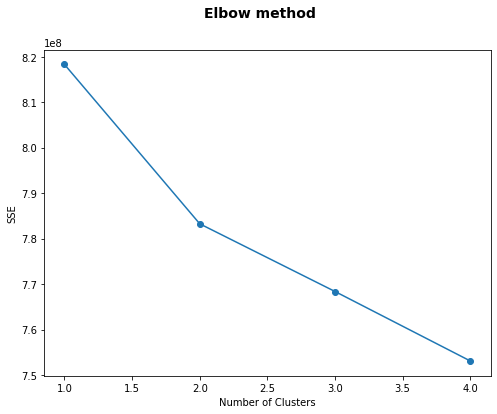

In [18]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define the range for K:
Nc = range(1, 5)

# Create the list of classifiers:
kmeans = [KMeans(n_clusters=i) for i in Nc]

# Calculate the SSE for each classifier:
# Inertia: Sum of distances of samples to their closest cluster center
SSE = [kmeans[i].fit(vgg16_feature_list_np).inertia_ for i in range(len(kmeans))]

# Plot the results:
plt.figure(figsize=(8, 6))
plt.suptitle("Elbow method", fontsize=14, fontweight='bold')

plt.plot(Nc,SSE, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

plt.show()

Once introduced the elbow method to select the optimal number of clusters, we create and fit the model using `k=2` clusters. Indeed, there are two classes (two clusters) in our dataset (cats and dogs):

In [19]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(vgg16_feature_list_np)

# Predict the classes of test (new) images

First step it to create the function `predict_image()`, which predicts a new image and also to print the predicted label over the image

In [20]:
from google.colab.patches import cv2_imshow
import cv2

def predict_image(path_image):
  label = kmeans.predict(get_features(path_image).reshape(1,-1))[0]

  img = cv2.imread(path_image)
  cv2.putText(img, str(label), (20, 60), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)

  return img

Just create the path to some test images to see if our classifier is able to predict the correct label:

In [22]:
PATH_TEST_IMG_1 = '/content/test/test/10000.jpg'
PATH_TEST_IMG_2 = '/content/test/test/10001.jpg'
PATH_TEST_IMG_3 = '/content/test/test/10002.jpg'
PATH_TEST_IMG_4 = '/content/test/test/10003.jpg'
PATH_TEST_IMG_5 = '/content/test/test/10004.jpg'
PATH_TEST_IMG_6 = '/content/test/test/10005.jpg'
PATH_TEST_IMG_7 = '/content/test/test/10006.jpg'
PATH_TEST_IMG_8 = '/content/test/test/10007.jpg'
PATH_TEST_IMG_9 = '/content/test/test/10008.jpg'
PATH_TEST_IMG_10 = '/content/test/test/10009.jpg'
PATH_TEST_IMG_11 = '/content/test/test/10010.jpg'
PATH_TEST_IMG_12 = '/content/test/test/10011.jpg'
PATH_TEST_IMG_13 = '/content/test/test/10012.jpg'
PATH_TEST_IMG_14 = '/content/test/test/10013.jpg'
PATH_TEST_IMG_15 = '/content/test/test/10014.jpg'

Finally, call `predict_image()` using the test path images introduced above and also show the resulting image using `cv2_imshow()`

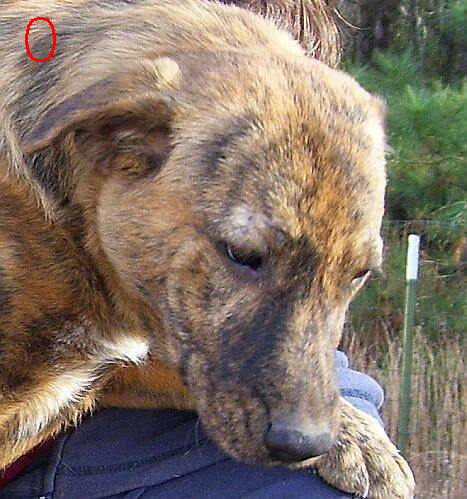

In [23]:
from google.colab.patches import cv2_imshow

cv2_imshow(predict_image(PATH_TEST_IMG_1))

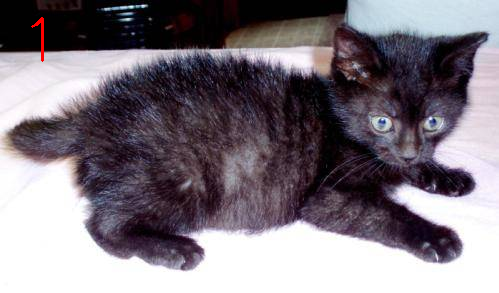

In [24]:
cv2_imshow(predict_image(PATH_TEST_IMG_2))

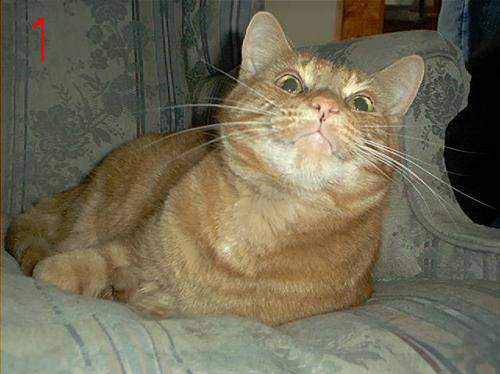

In [25]:
cv2_imshow(predict_image(PATH_TEST_IMG_3))

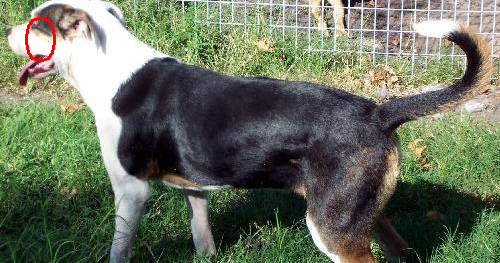

In [26]:
cv2_imshow(predict_image(PATH_TEST_IMG_4))

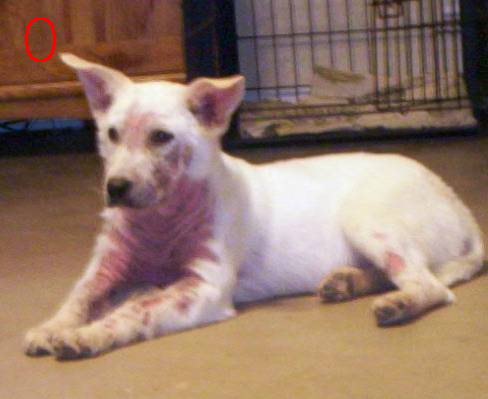

In [27]:
cv2_imshow(predict_image(PATH_TEST_IMG_5))

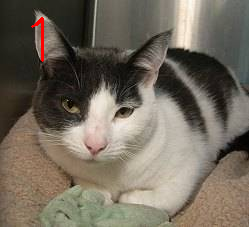

In [28]:
cv2_imshow(predict_image(PATH_TEST_IMG_6))

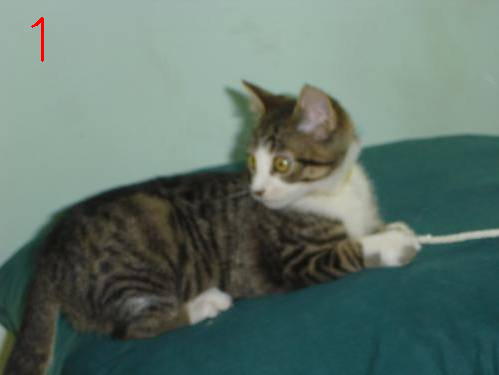

In [29]:
cv2_imshow(predict_image(PATH_TEST_IMG_7))

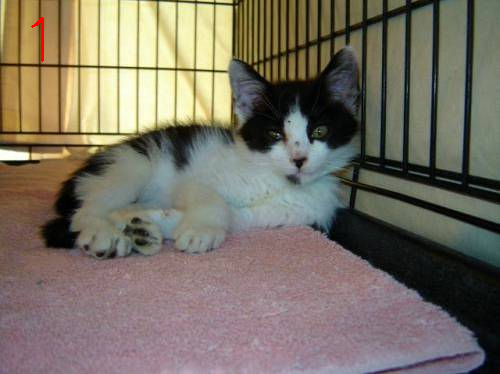

In [30]:
cv2_imshow(predict_image(PATH_TEST_IMG_8))

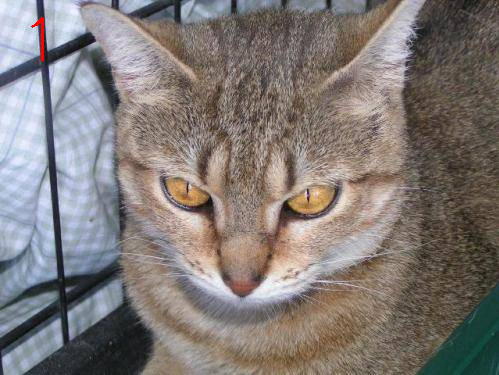

In [31]:
cv2_imshow(predict_image(PATH_TEST_IMG_9))

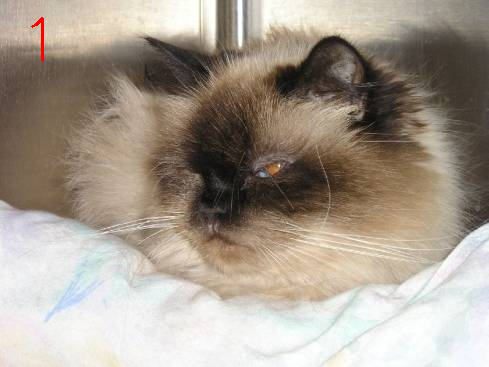

In [32]:
cv2_imshow(predict_image(PATH_TEST_IMG_10))

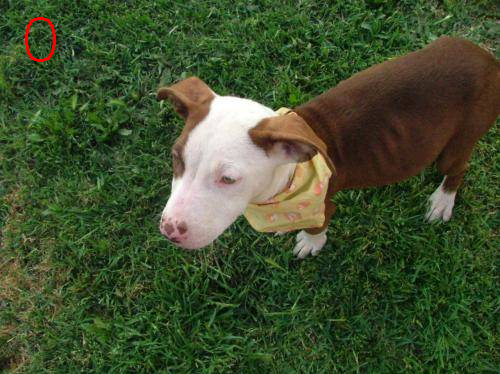

In [33]:
cv2_imshow(predict_image(PATH_TEST_IMG_11))

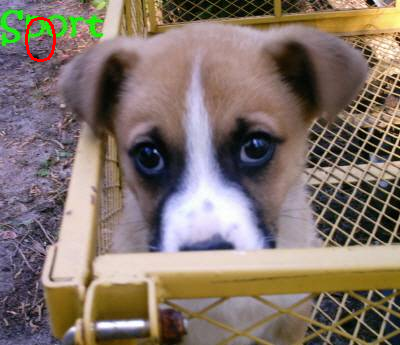

In [34]:
cv2_imshow(predict_image(PATH_TEST_IMG_12))

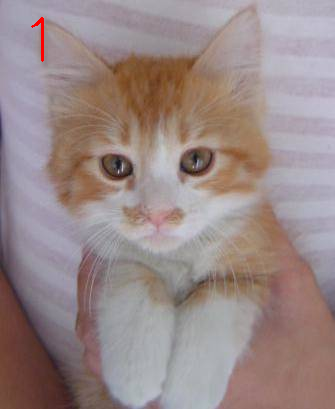

In [35]:
cv2_imshow(predict_image(PATH_TEST_IMG_13))

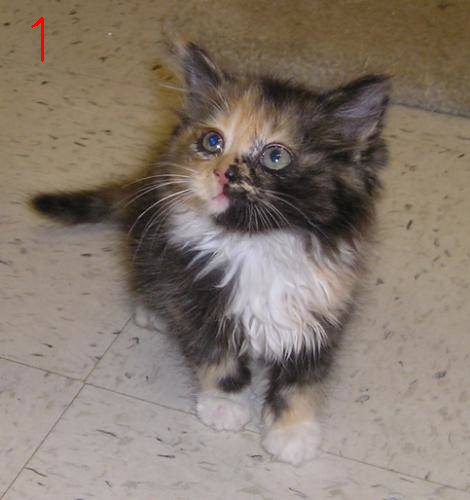

In [36]:
cv2_imshow(predict_image(PATH_TEST_IMG_14))

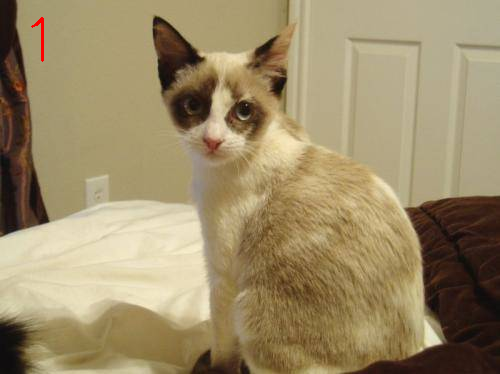

In [37]:
cv2_imshow(predict_image(PATH_TEST_IMG_15))

# Conclusions

In this notebook, we have seen how to use [Keras Applications ](https://keras.io/api/applications/) for feature extraction. In this example we have used the "Dogs vs. Cats Redux: Kernels Edition - Distinguish images of dogs from cats"  dataset from [Kaggle](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition). We have download the dataset using the Kaggle API. 

Therefore, we have performed feature extraction using a pre-trained [VGG16 model](https://keras.io/api/applications/vgg/#vgg16-function) using some images of the aforementioned dataset. This (and other models) are pre-trained on ImageNet. As it is loaded for feature extraction, we have not loaded the weights for the 3 fully-connected layers at the top of the network.

These extracted features are used to build a classifier to distinguish between cat and dog images. More specifically, we have trained a KMeans clustering algorithm included in [scikit-learn library](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). In connection with this point, we have also introduced the elbow method (or criterion), which can help in selecting the optimal number of clusters.

Finally, we have tested the classifier with some test images (as a simple "validation") to see that this approach can be used for transfer learning problems.